# Gini

## Pre-processing

    import

In [95]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

    read

In [2]:
loans_clean = pd.read_csv("../data/transformed/loans_cleaned.csv")

In [3]:
loans_clean.head()

,DESCRIPTION,LOAN_AMOUNT,LOAN_USE,TAGS,FEMALE_OPERATED,ORIGINAL_LANGUAGE_Arabic,ORIGINAL_LANGUAGE_English,ORIGINAL_LANGUAGE_French,ORIGINAL_LANGUAGE_Indonesian,ORIGINAL_LANGUAGE_Portuguese,...,SECTOR_NAME_Entertainment,SECTOR_NAME_Food,SECTOR_NAME_Health,SECTOR_NAME_Housing,SECTOR_NAME_Manufacturing,SECTOR_NAME_Personal Use,SECTOR_NAME_Retail,SECTOR_NAME_Services,SECTOR_NAME_Transportation,SECTOR_NAME_Wholesale
0,Emelisa is 32 years old. With two children in...,125.0,"to buy items to sell like beverages, canned go...",#Woman-Owned Business,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Samol is married and she lives with her husban...,1000.0,to purchase construction material.,"#Repair Renew Replace, #Parent",1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Abla is an unmarried woman living in Agoe. She...,200.0,"to buy 5 sacks of corn, 2 cans of oil, and a s...","#Woman-Owned Business, user_favorite",1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Emanuellita works hard to support six children...,100.0,to build a sanitary toilet,"#Health and Sanitation, #Eco-friendly",1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Leizel is 26 years old and married with one ch...,375.0,to buy livestock to raise,NaN,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


    downsample

In [4]:
downsampled_df = pd.DataFrame(loans_clean.sample(10000, replace=False, random_state=137))

    process

In [5]:
# grab set of stopwords from nltk and CV
sw = set(stopwords.words("english"))
cv = set(CountVectorizer(stop_words="english").get_stop_words())

# union of set extend with custom stopwords
stops = list(set(cv | sw))
stops.extend(["php", "kiva", "000", "br"])

# suggested custom stopwords
# "use", "loan", "like", "requested", "years", "old", "save", ... need more

##### to be moved to module consider sparse binary column for exceptionally positive description

In [6]:
def free_form_counter(df, column_name):
    """
    Free form text word and character counter.
    Takes a df and column. Returns a word count and character count(including white space) of
    column.
    
    df : a pandas dataframe
    column_name : a name of column in df
    """
    tmp_char_cnt = df[column_name].str.len()
    tmp_word_cnt = df[column_name].str.split().str.len()
    
    return tmp_chr_cnt, tmp_word_cnt

In [7]:
def free_form_processor(df, column_name, stops):
    """
    Free form text processor.
    Extracts words only, removes stop words, to lowercase, and strips white space.
    
    df : a pandas dataframe
    column_name : a name of a column in df
    stops : a list of stopwords
    """
    tmp = df[column_name].map(RegexpTokenizer(r"\w+").tokenize)
    tmp = tmp.map(lambda x: " ".join(x))
    tmp = tmp.map(str.lower)
    tmp = tmp.map(lambda x: " ".join(w for w in x.split() if w not in stops))
    tmp = tmp.map(str.strip)
    
    return tmp

In [8]:
def free_form_sent(df, column_name):
    """
    Freem form text sentiment analyzer.
    Analyzes sentiment of text returns a dataframe with scores as columns
    
    df : a pandas dataframe
    column_name : a name of a column in df
    """
    sia = SentimentIntensityAnalyzer()

    sent_dict_df = df[column_name].map(lambda x: sia.polarity_scores(x))
    sent_df   = sent_dict_df.map(lambda x: [v for k, v in x.items()]).apply(pd.Series)
    
    return sent_df.set_axis(["NEGATIVE" + column_name, "NEUTRAL" + column_name, "POSITIVE" + column_name, "COMPOUND" + column_name], axis = 1, inplace=True)

    tokenize

In [9]:
downsampled_df["PROCESSED_DESCRIPTION"] = free_form_processor(downsampled_df, "DESCRIPTION", stops)

In [161]:
downsampled_df["PROCESSED_DESCRIPTION"].head(10)

577279     monicah 37 years old married 5 children n nshe...
1000075    ms saphie g widow mother children 48 years old...
1710553    nagina 58 year old married women running small...
395209     virginia 54 years old sells crabs home husband...
2053403    saturnino went school seventh grade parents he...
500252     sreyhorn group lives rural village pailin prov...
1904327    sengee age 41 professional tractor driver live...
1076334    mary c 40 years old married business man coupl...
1692406    community group virgen itati pilar city female...
977337     melona 41 years old children melona married ch...
Name: PROCESSED_DESCRIPTION, dtype: object

In [97]:
downsampled_df.drop(downsampled_df\
                    [downsampled_df["TAGS"].str.replace("#", "").str.split(", ").isnull()].index)\
                    ["TAGS"].str.replace("#", "").str.split(", ").apply(pd.Series).stack().value_counts()

user_favorite                     4810
Woman-Owned Business              2236
Parent                            2185
Repeat Borrower                   1241
Elderly                            841
Animals                            641
Schooling                          631
Eco-friendly                       604
Vegan                              516
Biz Durable Asset                  437
Health and Sanitation              423
Technology                         337
volunteer_pick                     326
Fabrics                            279
Single Parent                      236
Single                             217
Supporting Family                  202
First Loan                         195
Repair Renew Replace               193
volunteer_like                     175
Sustainable Ag                     161
Widowed                            150
Job Creator                        104
Female Education                    83
Trees                               82
Refugee                  

### n-grams

    unigrams

In [11]:
# Count vectorizer is instantiated
cv_uni = CountVectorizer(
    min_df = 0.0001,
    max_df = 1.0,
    ngram_range = (1,1),
    max_features = 1000
)

uni = cv_uni.fit_transform(downsampled_df["PROCESSED_DESCRIPTION"])
df_uni  = pd.DataFrame(uni.todense().astype(np.uint8), columns=cv_uni.get_feature_names_out())

cnt_df_uni = df_uni.sum().sort_values(ascending=False)
cnt_df_uni.to_csv("../data/transformed/description_unigrams.csv")

In [121]:
df_cnt_uni = pd.read_csv("../data/transformed/description_unigrams.csv", names=["unigram", "count"])
#df_cnt_uni[2:25]

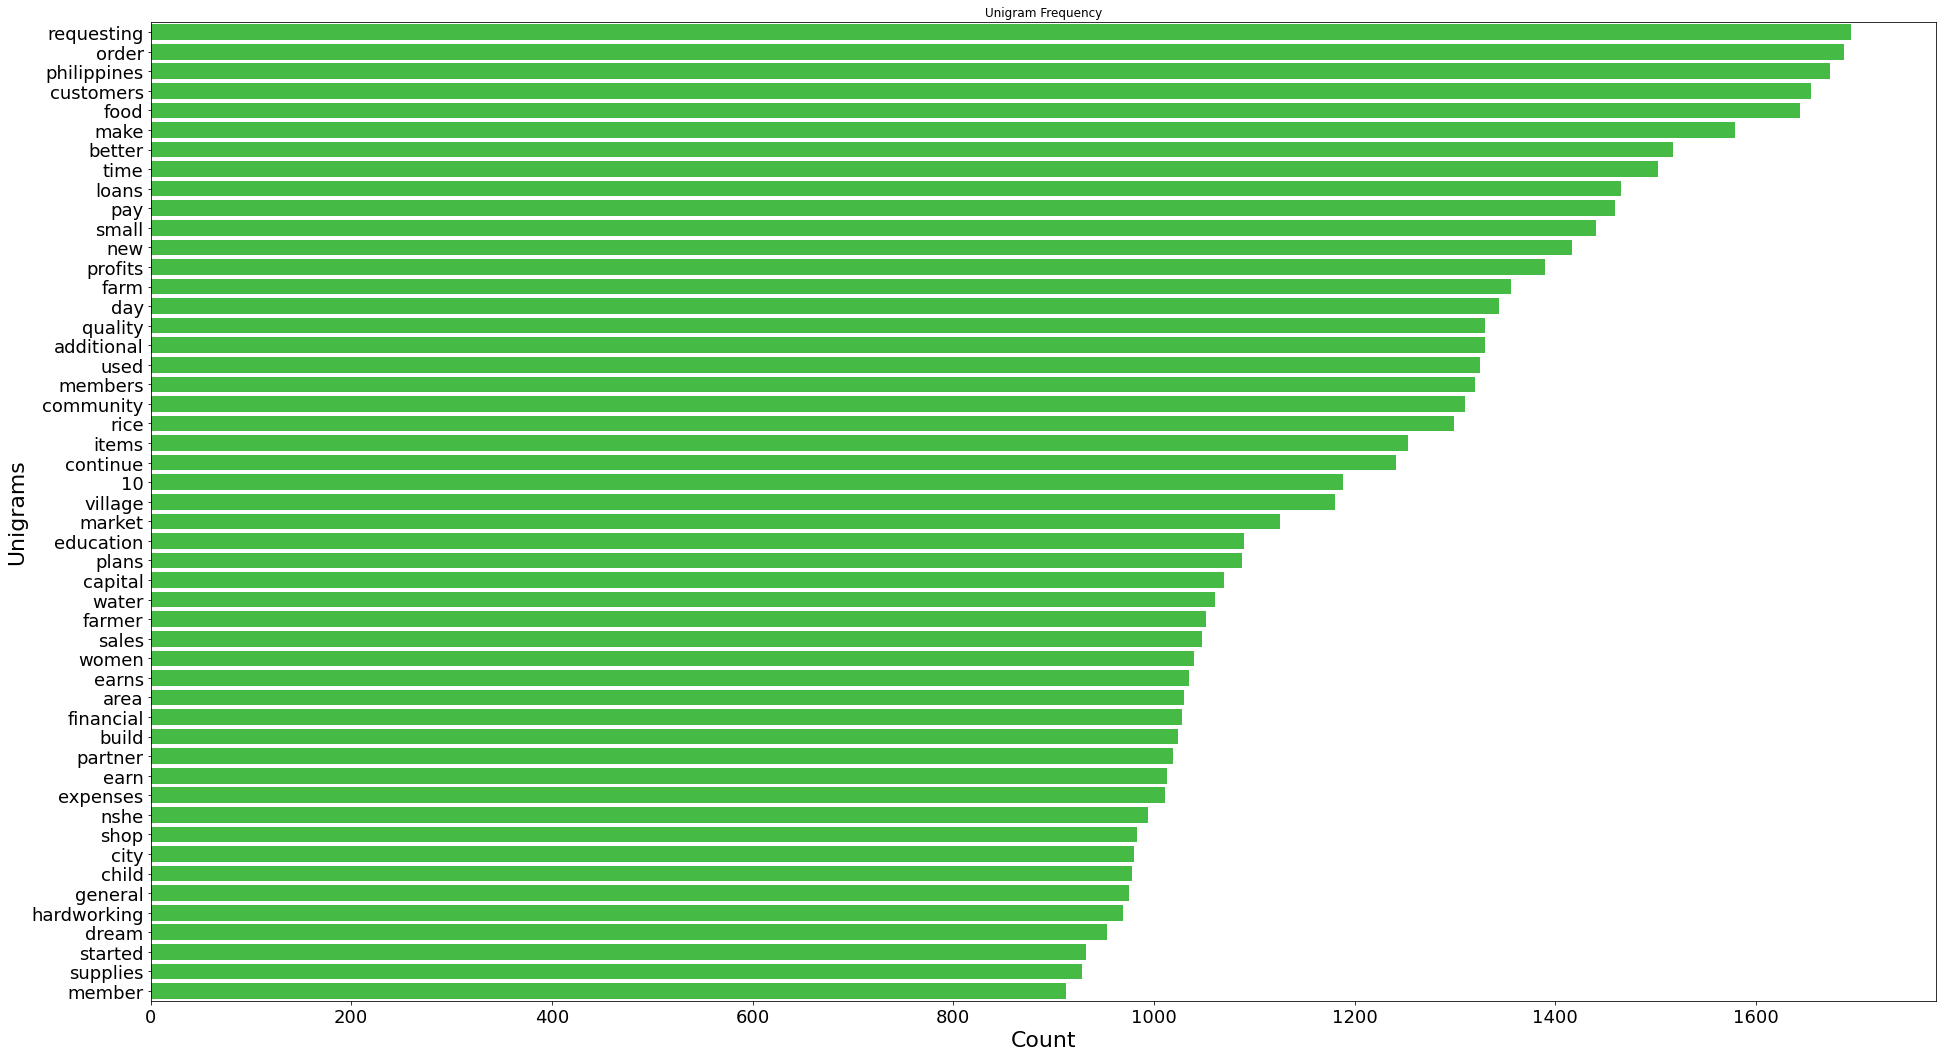

In [123]:
plt.figure(figsize=(32,18))

sns.barplot(data = df_cnt_uni[50:100], x = "count", y = "unigram", orient = "h", color="limegreen")

plt.title("Unigram Frequency")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Unigrams", fontsize=22)
plt.xlabel("Count", fontsize=22);

    bigrams

In [14]:
# Count vectorizer is instantiated
cv_bi = CountVectorizer(
    min_df = 0.0001,
    max_df = 1.0,
    ngram_range = (2,2),
    max_features= 1000
)

bi = cv_bi.fit_transform(downsampled_df["PROCESSED_DESCRIPTION"])
df_bi  = pd.DataFrame(bi.todense().astype(np.uint8), columns=cv_bi.get_feature_names_out())
cnt_df_bi = df_bi.sum().sort_values(ascending=False)
cnt_df_bi.to_csv("../data/transformed/description_bigrams.csv")

In [118]:
df_cnt_bi = pd.read_csv("../data/transformed/description_bigrams.csv", names=["bigram", "count"])
#df_cnt_bi[2:25]

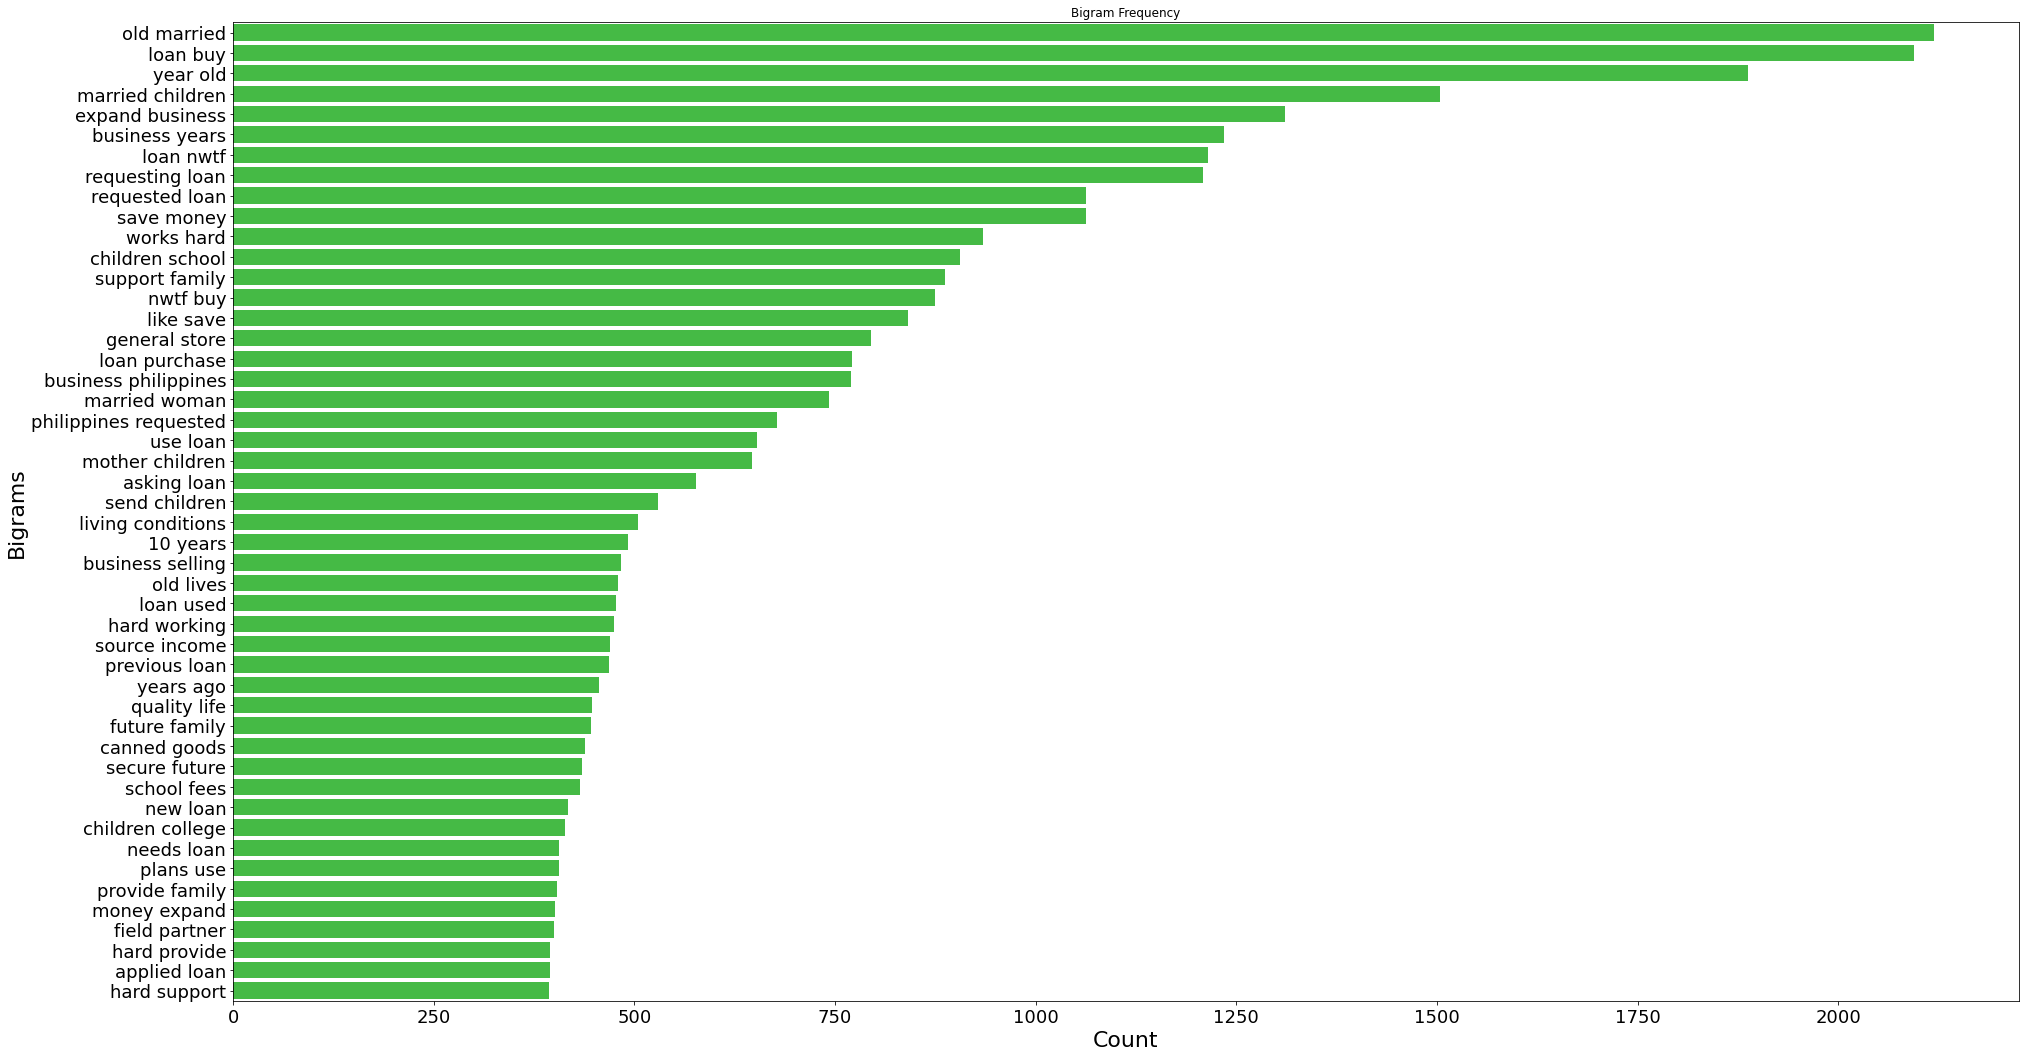

In [119]:
plt.figure(figsize=(32,18))

sns.barplot(data = df_cnt_bi[2:50], x = "count", y = "bigram", orient = "h", color="limegreen")

plt.title("Bigram Frequency")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Bigrams", fontsize=22)
plt.xlabel("Count", fontsize=22);

    trigrams

In [17]:
# Count vectorizer is instantiated
cv_tri = CountVectorizer(
    min_df = 0.0001,
    max_df = 1.0,
    ngram_range = (3,3),
    max_features= 1000
)

tri = cv_tri.fit_transform(downsampled_df["PROCESSED_DESCRIPTION"])
df_tri  = pd.DataFrame(tri.todense().astype(np.uint8), columns=cv_tri.get_feature_names_out())
cnt_df_tri = df_tri.sum().sort_values(ascending=False)
cnt_df_tri.to_csv("../data/transformed/description_trigrams.csv")

In [115]:
df_cnt_tri = pd.read_csv("../data/transformed/description_trigrams.csv", names=["trigram", "count"])
#df_cnt_tri[2:25]

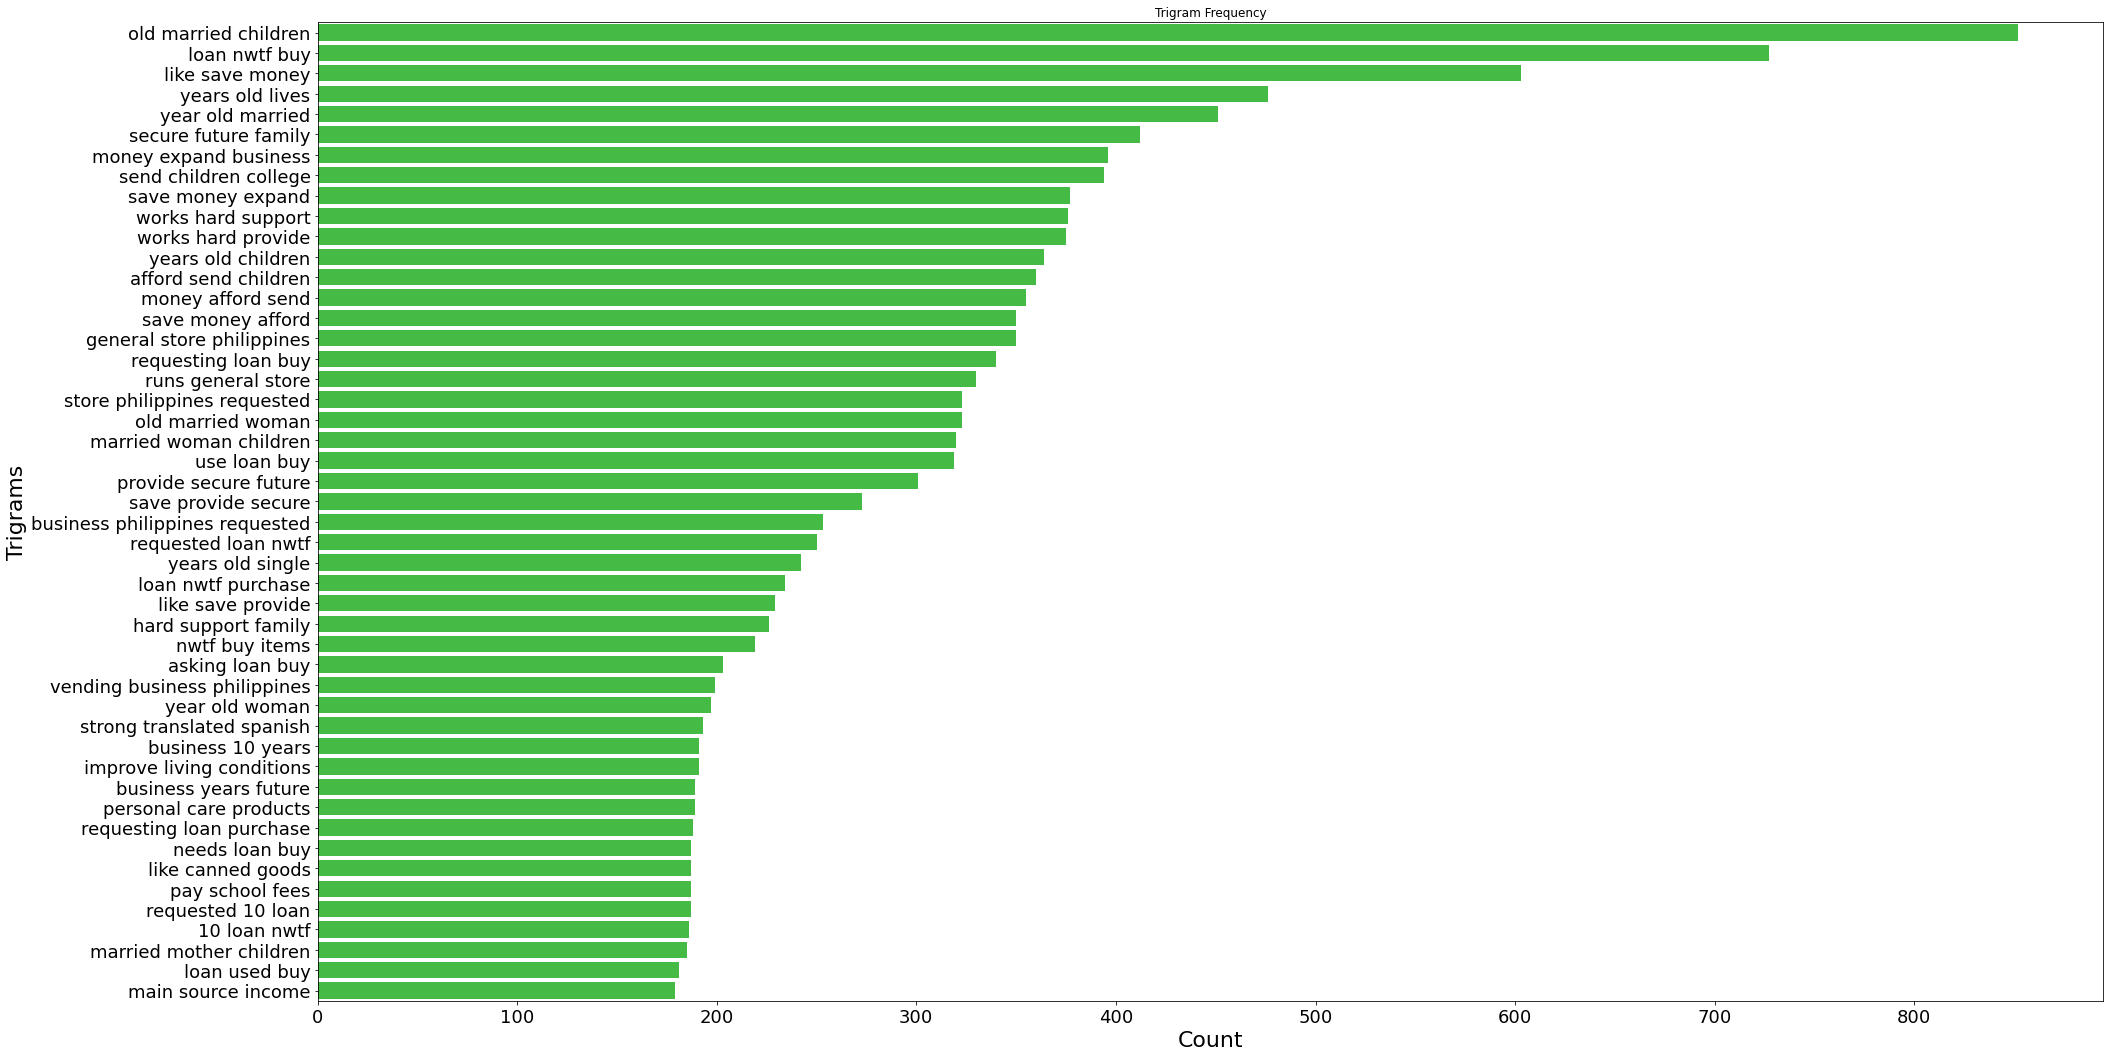

In [117]:
plt.figure(figsize=(32,18))

sns.barplot(data = df_cnt_tri[2:50], x = "count", y = "trigram", orient = "h", color="limegreen")

plt.title("Trigram Frequency")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Trigrams", fontsize=22)
plt.xlabel("Count", fontsize=22);

### Tags to Items

In [129]:
downsampled_df["PROCESSED_DESCRIPTION"]

577279     monicah 37 years old married 5 children n nshe...
1000075    ms saphie g widow mother children 48 years old...
1710553    nagina 58 year old married women running small...
395209     virginia 54 years old sells crabs home husband...
2053403    saturnino went school seventh grade parents he...
                                 ...                        
758325     farie 22 year old mother children personality ...
109890     emprendedoras kuña guapa group 3rd cycle women...
388177     p ama married seven dependents sells food supp...
1477550    anayat lives kasur small city located punjab f...
1782185    arlene married woman children hard working ent...
Name: PROCESSED_DESCRIPTION, Length: 10000, dtype: object

In [151]:
downsampled_df["TAGSsans#"] = downsampled_df["TAGS"].str.replace("#", "").str.split(", ")
ngrams = ["years"]
downsampled_df["TAGSsans#"] + downsampled_df["PROCESSED_DESCRIPTION"].map(lambda x: list(set([g for g in x.split() if g in ngrams])))

577279      [Parent, Woman-Owned Business, Schooling, years]
1000075                                                  NaN
1710553                                     [Elderly, years]
395209                                                   NaN
2053403                       [Parent, user_favorite, years]
                                 ...                        
758325                        [Repair Renew Replace, Parent]
109890     [Woman-Owned Business, Repeat Borrower, user_f...
388177                                                   NaN
1477550                                                  NaN
1782185                                                  NaN
Length: 10000, dtype: object

In [159]:
# only works for unigrams right now this might be sufficient.

unigrams                    = ["years"]   #example manually selects unigram to add as tag

downsampled_df["TAGS"].fillna("", inplace = True) # NaNs do not allow list extension

downsampled_df["TAGSsans#"] = downsampled_df["TAGS"].str.replace("#", "").str.split(", ") #removing #

downsampled_df["TAGS+"]     = downsampled_df["TAGSsans#"] +\
                              downsampled_df["PROCESSED_DESCRIPTION"].map(lambda x: list(\
                              set([g for g in x.split() if g in ngrams]))) # find unigrams in
                                                                           # processed description

In [160]:
downsampled_df["TAGS+"].head()

577279     [Parent, Woman-Owned Business, Schooling, years]
1000075                                           [, years]
1710553                                    [Elderly, years]
395209                                            [, years]
2053403                      [Parent, user_favorite, years]
Name: TAGS+, dtype: object

In [113]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.
# LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer

# Demonstrated with TAGS, to be changed to TAGS+

mlb = MultiLabelBinarizer(sparse_output=True)

pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(downsampled_df.drop(downsampled_df\
                    [downsampled_df["TAGS"].str.replace("#", "").str.split(", ").isnull()].index)\
                    ["TAGS"].str.replace("#", "").str.split(", ")),
                    columns = mlb.classes_).head()

,Animals,Biz Durable Asset,Eco-friendly,Elderly,Fabrics,Female Education,First Loan,Health and Sanitation,Hidden Gem,Inspiring Story,...,Trees,US Black-Owned Business,US immigrant,Unique,Vegan,Widowed,Woman-Owned Business,user_favorite,volunteer_like,volunteer_pick
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


    export

In [ ]:
#df.reset_index(inplace=True, drop=True)
#df_clean.to_csv("../data/transformed/preprocessed_df_data.csv")